In [17]:
import sys
import os

print("=" * 70)
print("NOTEBOOK ENVIRONMENT INFORMATION")
print("=" * 70)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"Current working directory: {os.getcwd()}")
print(f"Virtual environment: {os.path.basename(sys.prefix)}")
print("=" * 70)

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs
import pypfopt as ppo
import torch as th

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, PPO, DDPG, SAC
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from typing import Tuple
from stable_baselines3.common.policies import BasePolicy

import onnx
import onnxruntime as ort
import onnxscript

NOTEBOOK ENVIRONMENT INFORMATION
Python executable: c:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio\.venv_fresh\Scripts\python.exe
Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Current working directory: c:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio
Virtual environment: .venv_fresh


In [18]:
import importlib
import sys

# Clear any cached modules to force fresh import
if 'utils' in sys.modules:
    del sys.modules['utils']
if 'models' in sys.modules:
    del sys.modules['models']
if 'portfolio_env' in sys.modules:
    del sys.modules['portfolio_env']

import utils
import models
import portfolio_env


✓ Hyperparameter tracking initialized!


# Data Loading & Preprocessing

## Data Extraction

In [19]:
start = '2010-01-01'
end = '2024-12-31'
# tickers = ['SPY','QQQ','IWM','AGG','TLT','IEF','SHY','GLD','UUP','FXE','FXY','FXB']
tickers=  ['SPY','SHY','GLD','FXY']

raw_data = yf.download(tickers, start=start, end=end, group_by='ticker')

# download close prices of all tickers
data = pd.DataFrame()
for ticker in tickers:
    data[ticker] = raw_data[ticker]['Close']

[*********************100%***********************]  4 of 4 completed


## Exploratory Data Analysis

In [20]:
data_ret = data.pct_change().dropna()

In [21]:
data_ret.corr()

,SPY,SHY,GLD,FXY
SPY,1.000000,-0.121995,0.054781,-0.211319
SHY,-0.121995,1.000000,0.308830,0.466729
GLD,0.054781,0.308830,1.000000,0.349730
FXY,-0.211319,0.466729,0.349730,1.000000


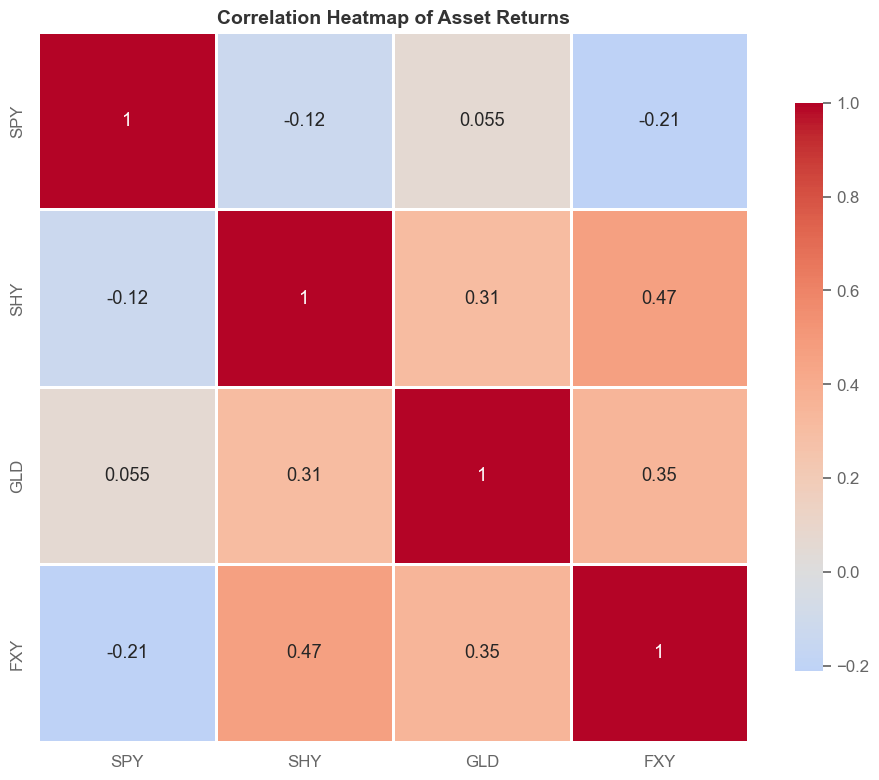

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_ret.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Asset Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
# export the data
data.to_csv('tables/price_data.csv')

## calculate risk free rate

In [24]:
rf_data = pd.read_csv('tables/TB3MS.csv', index_col=0, parse_dates=True)
rf_rate = rf_data['TB3MS'].mean()
rf_rate

np.float64(1.2088333333333332)

# Benchmark Model

## Buy and Hold

In [25]:
buy_and_hold_results = utils.buy_and_hold(price_data=data, port_initial_date='2021-12-31', initial_capital=1000000)
buy_and_hold_results['annualized_return']

'3.27%'

In [26]:
# Store formatted results for CSV export
buy_and_hold_results = pd.DataFrame({k: v for k, v in buy_and_hold_results.items() if k != 'current_weights'})

buy_and_hold_results.to_csv('tables/holding_portfolio_results.csv')

In [27]:
# Extract portfolio values with dates (index) for technical indicators
buy_and_hold_portfolio = pd.DataFrame({
    'date': buy_and_hold_results['portfolio_values'].index,
    'portfolio_value': buy_and_hold_results['portfolio_values'].values
})

# Append technical indicators to portfolio values data
buy_and_hold_results_ta = utils.cal_indicator(buy_and_hold_portfolio.set_index('date'), port_initial_date='2022-01-01')

buy_and_hold_results_ta.to_csv('tables/holding_portfolio_results_ta.csv')

## Mean-Variance Optimization

In [28]:
MVO_1y_lookback = utils.rebalance_portfolio(price_data=data,
                                           port_initial_date='2022-01-03',
                                           lookback_period=21,
                                           bounds=(0,1),
                                           mode='max_sharpe'
                                           )

MVO_1y_lookback['annualized_return']

C:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio\.venv_fresh\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio\.venv_fresh\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio\.venv_fresh\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio\.venv_fresh\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try a

'-10.27%'

In [29]:
MVO_1y_lookback = pd.DataFrame({k: v for k, v in MVO_1y_lookback.items() if k != 'current_weights'})
MVO_1y_lookback.to_csv('tables/mvo_portfolio_results.csv')

# Reinforcement Learning

## Robustness Testing

### A2C

In [ ]:
# set the hyperparameters
policy_kwargs = {"log_std_init": 0.5}

a2c_hyperparams = {
    'learning_rate': 0.0005,
    'n_steps': 256,
    'batch_size': None,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ent_coef': 0.02,  # INCREASED from 0.001 - penalize entropy loss more to maintain exploration
    'vf_coef': 0.5,
    'buffer_size': None,
    'tau': None,
}

# Define seeds for testing
seeds = [0, 25, 50, 75, 100]  # 5 different random seeds

# train and test the model with multiple seeds
a2c_multi_seed_results = models.conduct_multi_seed_rolling_test(
    model_class=A2C,
    price_data=data,
    train_start_date='2010-01-01',
    train_end_date='2018-12-31',
    test_end_date='2024-12-31',
    total_timesteps=600000,
    eval_episodes=10,    
    learning_rate=a2c_hyperparams['learning_rate'],
    n_steps=a2c_hyperparams['n_steps'],
    gamma=a2c_hyperparams['gamma'],
    gae_lambda=a2c_hyperparams['gae_lambda'],
    ent_coef=a2c_hyperparams['ent_coef'],
    vf_coef=a2c_hyperparams['vf_coef'],
    seeds=seeds,
    verbose=1,
    policy_kwargs=policy_kwargs,
)

# export the multi-seed results
models.export_multi_seed_results_to_csv(a2c_multi_seed_results, 'tables/a2c_multi_seed')
models.export_multi_seed_hyperparameters_to_csv(a2c_multi_seed_results, 'tables/a2c_multi_seed_summary.csv')


MULTI-SEED ROLLING TEST: A2C
Total Seeds: 5
Seeds: [0, 25, 50, 75, 100]


>>> Running test with seed: 0

ITERATION 0
Training: 2010-01-01 to 2018-12-31
Testing: 2019-01-01 to 2019-12-31
Starting Capital: $1,000,000.00
Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 678      |
|    iterations         | 100      |
|    time_elapsed       | 37       |
|    total_timesteps    | 25600    |
| train/                |          |
|    entropy_loss       | -7.77    |
|    explained_variance | -0.926   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -5.24    |
|    std                | 1.69     |
|    value_loss         | 0.705    |
------------------------------------


### PPO

In [ ]:
# set the hyperparameters
policy_kwargs = {
    "log_std_init": 0.5,  
    "net_arch": {"pi": [256, 256], "vf": [256, 256]},  
}

ppo_hyperparams = {
    'learning_rate': 0.0001,
    'n_steps': 256,  
    'batch_size': 128,  
    'gamma': 0.99,
    'gae_lambda': 0.98,
    'ent_coef': 0.1,  
    'vf_coef': 0.5,
}


# train and test the model
ppo_multi_seed_results = models.conduct_rolling_robustness_test(
    model_class=PPO,
    price_data=data,
    train_start_date='2010-01-01',
    train_end_date='2018-12-31',
    test_end_date='2024-12-31',
    total_timesteps=600000,
    eval_episodes=10,
    learning_rate=ppo_hyperparams['learning_rate'],
    n_steps=ppo_hyperparams['n_steps'],
    batch_size=ppo_hyperparams['batch_size'],
    gamma=ppo_hyperparams['gamma'],
    gae_lambda=ppo_hyperparams['gae_lambda'],
    ent_coef=ppo_hyperparams['ent_coef'],
    vf_coef=ppo_hyperparams['vf_coef'],
    seeds=seeds,
    verbose=1,
    policy_kwargs=policy_kwargs,
)


# export the outputs
models.export_multi_seed_results_to_csv(ppo_multi_seed_results, 'tables/ppo_multi_seed')
models.export_multi_seed_hyperparameters_to_csv(ppo_multi_seed_results, 'tables/ppo_multi_seed_summary.csv')

### DDPG

In [ ]:
# set the hyperparameters
ddpg_hyperparams = {
    'learning_rate': 2e-4, 
    'n_steps': None,
    'batch_size': 256,
    'gamma': 0.99,
    'gae_lambda': None,
    'ent_coef': None,
    'vf_coef': None,
    'buffer_size': 200000,  
    'tau': 0.005, 
}

# Create action noise for exploration
n_actions = 4  # Number of assets
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.08 * np.ones(n_actions)
)

# train and test the model
ddpg_multi_seed_results = models.conduct_rolling_robustness_test(
    model_class=DDPG,
    price_data=data,
    train_start_date='2010-01-01',
    train_end_date='2018-12-31',
    test_end_date='2024-12-31',
    total_timesteps=150000,
    eval_episodes=10,
    learning_rate=ddpg_hyperparams['learning_rate'],
    batch_size=ddpg_hyperparams['batch_size'],
    gamma=ddpg_hyperparams['gamma'],
    buffer_size=ddpg_hyperparams['buffer_size'],
    tau=ddpg_hyperparams['tau'],
    action_noise=action_noise,
    seeds=seeds,
    verbose=1,
)

# export the outputs
models.export_multi_seed_results_to_csv(ddpg_multi_seed_results, 'tables/ddpg_multi_seed')
models.export_multi_seed_hyperparameters_to_csv(ddpg_multi_seed_results, 'tables/ddpg_multi_seed_summary.csv')

### SAC

In [ ]:
# set the hyperparameters
sac_hyperparams = {
    'learning_rate': 5e-2,  
    'n_steps': None,
    'batch_size': 128,  
    'gamma': 0.99,
    'gae_lambda': None,
    'ent_coef': 0.01,  
    'vf_coef': None,
    'buffer_size': 150000,
    'tau': 0.01,
}

# train and test the model
sac_multi_seed_results = models.conduct_rolling_robustness_test(
    model_class=SAC,
    price_data=data,
    train_start_date='2010-01-01',
    train_end_date='2018-12-31',
    test_end_date='2024-12-31',
    total_timesteps=150000,
    eval_episodes=10,
    learning_rate=sac_hyperparams['learning_rate'],
    batch_size=sac_hyperparams['batch_size'],
    gamma=sac_hyperparams['gamma'],
    ent_coef=sac_hyperparams['ent_coef'],
    buffer_size=sac_hyperparams['buffer_size'],
    tau=sac_hyperparams['tau'],
    seeds=seeds,
    verbose=1,
)


# export the outputs
models.export_multi_seed_results_to_csv(sac_multi_seed_results, 'tables/sac_multi_seed')
models.export_multi_seed_hyperparameters_to_csv(sac_multi_seed_results, 'tables/sac_multi_seed_summary.csv')

# Single Split Testing (deprecated)

## Environment Building and Testing

In [264]:
env = portfolio_env.PortfolioEnv(price_data=data, lookback_period=252, initial_capital=1000000, bounds=(0,1), transaction_cost=0.0015, risk_aversion=0.05, reward_scale=0.1)
check_env(env)

C:\Users\abejr\OneDrive\Uniworks\PW25\Thesis\rl_portfolio\.venv_fresh\Lib\site-packages\stable_baselines3\common\env_checker.py:507: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [265]:
train_env, test_env = models.split_build_normalize_env(price_data=data,
                                                       port_initial_date='2022-01-01',
                                                       lookback_period=21)

## A2C

### A2C - Training

In [ ]:
# train the model with optimized hyperparameters for ~1.2% return
policy_kwargs = {"log_std_init": 0.5}

a2c_hyperparams = {
    'learning_rate': 0.0005,
    'n_steps': 256,
    'batch_size': None,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ent_coef': 0.02,  # INCREASED from 0.001 - penalize entropy loss more to maintain exploration
    'vf_coef': 0.5,
    'buffer_size': None,
    'tau': None,
}

a2c_model = A2C(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=a2c_hyperparams['learning_rate'],
    n_steps=a2c_hyperparams['n_steps'],
    gamma=a2c_hyperparams['gamma'],
    gae_lambda=a2c_hyperparams['gae_lambda'],
    ent_coef=a2c_hyperparams['ent_coef'],
    vf_coef=a2c_hyperparams['vf_coef'],
    verbose=1,
    seed=42,
    policy_kwargs=policy_kwargs
)

# Train and capture final info
a2c_model.learn(total_timesteps=600000)  # INCREASED from 600k - more data for stable learning

# Copy normalization statistics
test_env.obs_rms = train_env.obs_rms
test_env.ret_rms = train_env.ret_rms

# save the model
a2c_model.save("model/a2c_portfolio_model.zip")
print("✓ A2C model trained and saved")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 607      |
|    iterations         | 100      |
|    time_elapsed       | 42       |
|    total_timesteps    | 25600    |
| train/                |          |
|    entropy_loss       | -7.88    |
|    explained_variance | -0.583   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -1.52    |
|    std                | 1.74     |
|    value_loss         | 0.0979   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 593      |
|    iterations         | 200      |
|    time_elapsed       | 86       |
|    total_timesteps    | 51200    |
| train/                |          |
|    entropy_loss       | -8.02    |
|    explained_variance | 0.564    |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss     

### A2C - Testing

In [ ]:
a2c_model_loaded = A2C.load("a2c_portfolio_model_0149.zip")
a2c_results = models.evaluate_model_sb3(a2c_model_loaded, test_env, num_episodes=10)

print(f"A2C Annualized Return: {a2c_results['annualized_return']:.4f}")

# log results to hyperparameter tracking
utils.log_hpt_results(
    model_name='A2C',
    hyperparams=a2c_hyperparams,
    total_timesteps=600000,
    eval_results=a2c_results
)

# save scalar results
a2c_results_df = pd.DataFrame({k: [v] for k, v in a2c_results.items() if not isinstance(v, np.ndarray)})
a2c_results_df.to_csv('tables/a2c_portfolio_results.csv', index=False)

# save portfolio values in separated csv files
a2c_results['portfolio_df'].to_csv('tables/a2c_portfolio_values.csv', index=False)

A2C Annualized Return: 0.0149
✓ Logged A2C results to tables/hpt_log.csv


## PPO

### PPO - Training

In [349]:
policy_kwargs = {
    "log_std_init": 0.5,  
    "net_arch": {"pi": [256, 256], "vf": [256, 256]},  
}

ppo_hyperparams = {
    'learning_rate': 0.0001,  # REDUCED from 0.0005 - too aggressive, caused instability
    'n_steps': 256,  
    'batch_size': 128,  # INCREASED from 64 - larger batches for gradient stability
    'gamma': 0.99,
    'gae_lambda': 0.98,
    'ent_coef': 0.05,  # DRASTICALLY REDUCED from 0.3 - was extreme entropy penalty causing collapse
    'vf_coef': 0.5,
}

ppo_model = PPO(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=ppo_hyperparams['learning_rate'],
    n_steps=ppo_hyperparams['n_steps'],
    batch_size=ppo_hyperparams['batch_size'],
    gamma=ppo_hyperparams['gamma'],
    gae_lambda=ppo_hyperparams['gae_lambda'],
    clip_range=0.2,
    ent_coef=ppo_hyperparams['ent_coef'],
    n_epochs=5,  # REDUCED from 10 - prevent overfitting with large batches
    max_grad_norm=0.5,
    verbose=1,
    seed=42,
    policy_kwargs=policy_kwargs
)

ppo_model.learn(total_timesteps=600000)

# Copy normalization statistics
test_env.obs_rms = train_env.obs_rms
test_env.ret_rms = train_env.ret_rms

# save the model
ppo_model.save("model/ppo_portfolio_model.zip")
print("✓ PPO model trained and saved")

Using cpu device
----------------------------
| time/              |     |
|    fps             | 634 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 256 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 538           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00030417577 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.68         |
|    explained_variance   | -8.99         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.173        |
|    n_updates            | 5             |
|    policy_gradient_loss | -0.00703      |
|    std                  | 1.65          |
|    value_loss           | 0.64

### PPO - Testing

In [366]:
# load and evaluate the model
# ppo_model_loaded = PPO.load("model/ppo_portfolio_model.zip")
ppo_model_loaded = PPO.load("ppo_portfolio_model_0061.zip")
ppo_results = models.evaluate_model_sb3(ppo_model_loaded, test_env, num_episodes=10)

print(f"PPO Annualized Return: {ppo_results['annualized_return']:.4f}")

# log results to hyperparameter tracking
utils.log_hpt_results(
    model_name='PPO',
    hyperparams=ppo_hyperparams,
    total_timesteps=600000,
    eval_results=ppo_results
)

# save scalar results
ppo_results_df = pd.DataFrame({k: [v] for k, v in ppo_results.items() if not isinstance(v, np.ndarray)})
ppo_results_df.to_csv('tables/ppo_portfolio_results.csv', index=False)

# save portfolio values in separated csv files
ppo_results['portfolio_df'].to_csv('tables/ppo_portfolio_values.csv', index=False)

PPO Annualized Return: 0.0061
✓ Logged PPO results to tables/hpt_log.csv


## DDPG

### DDPG - Training

In [ ]:
# Extract number of actions from the environment
n_actions = train_env.action_space.shape[-1]
print(f"Number of actions: {n_actions}")

action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.08 * np.ones(n_actions)  # REDUCED from 0.2 - allow actor to learn coherent policy
)

ddpg_hyperparams = {
    'learning_rate': 2e-4,  # INCREASED from 5e-5 - 4x faster for meaningful updates
    'n_steps': None,
    'batch_size': 256,
    'gamma': 0.99,
    'gae_lambda': None,
    'ent_coef': None,
    'vf_coef': None,
    'buffer_size': 200000,  # INCREASED from 100k - richer experience replay for stability
    'tau': 0.005,  # REDUCED from 0.015 - slower, more stable target network updates
}

ddpg_model = DDPG(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=ddpg_hyperparams['learning_rate'],
    buffer_size=ddpg_hyperparams['buffer_size'],
    learning_starts=10000,  # INCREASED from 5k - more random exploration before learning
    batch_size=ddpg_hyperparams['batch_size'],
    tau=ddpg_hyperparams['tau'],
    gamma=ddpg_hyperparams['gamma'],
    action_noise=action_noise,
    verbose=1,
    seed=42
)

ddpg_model.learn(total_timesteps=150000)  # INCREASED from 150k - more training steps needed

# Copy normalization statistics
test_env.obs_rms = train_env.obs_rms
test_env.ret_rms = train_env.ret_rms

# save the model
ddpg_model.save("model/ddpg_portfolio_model.zip")
print("✓ DDPG model trained and saved")

Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 204      |
|    time_elapsed    | 58       |
|    total_timesteps | 11992    |
| train/             |          |
|    actor_loss      | -0.00701 |
|    critic_loss     | 7.9e-05  |
|    learning_rate   | 0.0002   |
|    n_updates       | 1991     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 62       |
|    time_elapsed    | 383      |
|    total_timesteps | 23984    |
| train/             |          |
|    actor_loss      | -0.093   |
|    critic_loss     | 2.48e-05 |
|    learning_rate   | 0.0002   |
|    n_updates       | 13983    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 51       |
|    time_elapsed    | 703     

### DDPG - Testing

In [ ]:
# load and evaluate the model
ddpg_model_loaded = DDPG.load("ddpg_portfolio_model_0140.zip")
ddpg_results = models.evaluate_model_sb3(ddpg_model_loaded, test_env, num_episodes=10)

print(f"DDPG Annualized Return: {ddpg_results['annualized_return']:.4f}")

# log results to hyperparameter tracking
utils.log_hpt_results(
    model_name='DDPG',
    hyperparams=ddpg_hyperparams,
    total_timesteps=150000,
    eval_results=ddpg_results
)

# save scalar results
ddpg_results_df = pd.DataFrame({k: [v] for k, v in ddpg_results.items() if not isinstance(v, np.ndarray)})
ddpg_results_df.to_csv('tables/ddpg_portfolio_results.csv', index=False)

# save portfolio values in separated csv files
ddpg_results['portfolio_df'].to_csv('tables/ddpg_portfolio_values.csv', index=False)

DDPG Annualized Return: 0.0140
✓ Logged DDPG results to tables/hpt_log.csv


## SAC

### SAC - Training

In [382]:
sac_hyperparams = {
    'learning_rate': 5e-5,  # INCREASED from 2e-5 - actor needs faster meaningful updates
    'n_steps': None,
    'batch_size': 128,  # KEEP - stable batch size for gradient conditioning
    'gamma': 0.99,
    'gae_lambda': None,
    'ent_coef': 0.05,  # INCREASED from 0.01 (5x!) - MUST encourage exploration of different weights
    'vf_coef': None,
    'buffer_size': 150000,
    'tau': 0.01,
}

sac_model = SAC(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=sac_hyperparams['learning_rate'],
    buffer_size=sac_hyperparams['buffer_size'],
    learning_starts=10000,
    batch_size=sac_hyperparams['batch_size'],
    gamma=sac_hyperparams['gamma'],
    tau=sac_hyperparams['tau'],
    ent_coef=sac_hyperparams['ent_coef'],
    verbose=1,
    seed=42
)

sac_model.learn(total_timesteps=200000)

# Copy normalization statistics
test_env.obs_rms = train_env.obs_rms
test_env.ret_rms = train_env.ret_rms

# save the model
sac_model.save("model/sac_portfolio_model.zip")
print("✓ SAC model trained and saved")

Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 215      |
|    time_elapsed    | 55       |
|    total_timesteps | 11992    |
| train/             |          |
|    actor_loss      | -2.18    |
|    critic_loss     | 0.000762 |
|    ent_coef        | 0.05     |
|    learning_rate   | 5e-05    |
|    n_updates       | 1991     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 63       |
|    time_elapsed    | 378      |
|    total_timesteps | 23984    |
| train/             |          |
|    actor_loss      | -8.42    |
|    critic_loss     | 0.00196  |
|    ent_coef        | 0.05     |
|    learning_rate   | 5e-05    |
|    n_updates       | 13983    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12      

### SAC - Testing

In [383]:
# load and evaluate the model
# sac_model_loaded = SAC.load("model/sac_portfolio_model.zip")
sac_model_loaded = SAC.load("sac_portfolio_model_n0053.zip")
sac_results = models.evaluate_model_sb3(sac_model_loaded, test_env, num_episodes=10)

print(f"SAC Annualized Return: {sac_results['annualized_return']:.4f}")

# log results to hyperparameter tracking
utils.log_hpt_results(
    model_name='SAC',
    hyperparams=sac_hyperparams,
    total_timesteps=200000,
    eval_results=sac_results
)

# save scalar results
sac_results_df = pd.DataFrame({k: [v] for k, v in sac_results.items() if not isinstance(v, np.ndarray)})
sac_results_df.to_csv('tables/sac_portfolio_results.csv', index=False)

# save portfolio values in separated csv files
sac_results['portfolio_df'].to_csv('tables/sac_portfolio_values.csv', index=False)

SAC Annualized Return: -0.0053
✓ Logged SAC results to tables/hpt_log.csv


In [384]:
# Display the complete hyperparameter tracking log
hpt_log_df = pd.read_csv(utils.hpt_log_file)
print("\n" + "="*100)
print("HYPERPARAMETER TUNING LOG")
print("="*100)
display(hpt_log_df)


HYPERPARAMETER TUNING LOG


,timestamp,model_name,learning_rate,n_steps,batch_size,gamma,gae_lambda,ent_coef,vf_coef,buffer_size,tau,total_timesteps,annualized_return,sharpe_ratio,max_drawdown,annualized_volatility,sortino_ratio
0,2026-01-05T06:16:59.242639,A2C,0.00100,512.0,NaN,0.99,0.99,0.0001,0.5,NaN,NaN,800000,-0.026862,-0.569022,-0.234634,0.099929,NaN
1,2026-01-05T06:19:05.792765,A2C,0.00100,512.0,NaN,0.99,0.99,0.0001,0.5,NaN,NaN,800000,-0.026862,-0.569022,-0.234634,0.099929,NaN
2,2026-01-05T06:48:51.639838,PPO,0.00050,2048.0,512.0,0.99,0.99,0,0.5,NaN,NaN,600000,-0.066686,-0.930306,-0.281837,0.103929,NaN
3,2026-01-05T10:10:46.333540,DDPG,0.00010,NaN,256.0,0.99,NaN,NaN,NaN,30000.0,0.005,120000,0.058895,0.221094,-0.228421,0.130692,NaN
4,2026-01-05T13:53:13.919015,SAC,0.00030,NaN,256.0,0.99,NaN,auto,NaN,30000.0,0.005,120000,0.005882,-0.178872,-0.230759,0.134835,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2026-01-10T01:31:25.416567,PPO,0.00010,256.0,128.0,0.99,0.98,0.05,0.5,NaN,NaN,600000,0.006097,-0.227629,-0.189117,0.105008,-0.372451
93,2026-01-10T01:31:35.073931,PPO,0.00010,256.0,128.0,0.99,0.98,0.05,0.5,NaN,NaN,600000,0.006097,-0.227629,-0.189117,0.105008,-0.372451
94,2026-01-10T01:32:14.392698,PPO,0.00010,256.0,128.0,0.99,0.98,0.05,0.5,NaN,NaN,600000,0.006097,-0.227629,-0.189117,0.105008,-0.372451
95,2026-01-10T01:43:00.540773,PPO,0.00010,256.0,128.0,0.99,0.98,0.05,0.5,NaN,NaN,600000,0.006097,-0.227629,-0.189117,0.105008,-0.372451
